# 0. Prerequisites

Use the following code to get you started!

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import tensorflow.keras
import time
import imutils
import hashlib

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, Dense, Activation, Dropout, Flatten, Input
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from typing import List
from pathlib import Path
from imutils.video import VideoStream
from PIL import Image

In [ ]:
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

## Data preprocessing

### Data download

the data file is here:

https://drive.google.com/file/d/125R6BqHPlUZa2M0Y9HPXcLC2OE5P1YMl/view?usp=share_link


In [ ]:
!gdown 125R6BqHPlUZa2M0Y9HPXcLC2OE5P1YMl

Downloading...
From: https://drive.google.com/uc?id=125R6BqHPlUZa2M0Y9HPXcLC2OE5P1YMl
To: /content/dataset.zip
100% 258M/258M [00:03<00:00, 82.5MB/s]


In [ ]:
!unzip dataset.zip

### Create a dataset

Define some parameters for the loader:

In [ ]:
BATCH_SIZE = 64
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

It's good practice to use a validation split when developing your model. Even if here we already have training and validation, it's still worth learning how to do it. We will do the train/validation split within this training set. You will use 80% of the images for training and 20% for validation.

In [ ]:
import pathlib
data_dir = pathlib.Path("dataset/train")
val_dir = pathlib.Path("dataset/val")

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=1314520,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE,
  label_mode='categorical')

Found 25807 files belonging to 7 classes.
Using 20646 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  val_dir,
  validation_split=0.2,
  subset="validation",
  seed=1314520,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE,
  label_mode='categorical')

Found 2810 files belonging to 7 classes.
Using 562 files for validation.


You can find the class names in the `class_names` attribute on these datasets.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6']


In [ ]:
for image_batch, labels_batch in train_ds.take(1):
    print(f'Image shape: {image_batch.shape}')

Image shape: (64, 224, 224, 3)


# 1. Build your model with transfer learning

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 7, 7, 1280)


## Adding Image Augmentation

These are just a few of the options available (for more, see the Keras documentation).

- layers.RandomCrop
- layers.RandomFlip
- layers.RandomTranslation
- layers.RandomRotation
- layers.RandomZoom
- layers.RandomHeight
- layers.RandomWidth
- layers.RandomContrast

https://www.tensorflow.org/guide/keras/preprocessing_layers#image_data_augmentation

In [ ]:
# Let's Design proper Image Augmentation Layers
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    layers.experimental.preprocessing.RandomContrast(factor=(0.5, 1.5)),
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2))
])

## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all the layers.

In [ ]:
base_model.trainable = False

## Adding the top prediction layers

In [ ]:
prediction_model = tf.keras.Sequential([
    layers.GlobalAveragePooling2D(),
    # more layers can go in between (more dense layers, dropout, and etc)
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(64, activation="relu"),
    layers.Dense(len(label_map), activation="softmax")
])

In [ ]:
model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    prediction_model
])

optim = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optim)
image_batch.shape

TensorShape([64, 224, 224, 3])

In [ ]:
result_batch = model(image_batch)
result_batch.shape

TensorShape([64, 7])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (64, 224, 224, 3)         0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 sequential_4 (Sequential)   (64, 7)                   172679    
                                                                 
Total params: 2,430,663
Trainable params: 172,679
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: ignored

In [ ]:
# Train your model

# Don't forget to save your model
################################################################################
## For your project, change the directory to a Google Drive Folder for safety ##
################################################################################

checkpoint_path = Path('/content/drive/MyDrive/checkpoints/mobilenet/run1/')
checkpoint_path.mkdir(parents=True, exist_ok=True)
path_model = '/content/drive/MyDrive/checkpoints/mobilenet/run1/{epoch:02d}-{val_loss:.6f}.hdf5'
initial_epochs = 50
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    use_multiprocessing=True,
                    workers=4,
                    callbacks=[
                        ModelCheckpoint(filepath=path_model),
                        EarlyStopping(patience=15),
                        ReduceLROnPlateau(patience=6, factor=0.3)]
)

Epoch 1/50
323/323 [==============================] - 41s 109ms/step - loss: 1.8941 - accuracy: 0.2220 - val_loss: 1.8257 - val_accuracy: 0.2224 - lr: 1.0000e-04
Epoch 2/50
323/323 [==============================] - 35s 107ms/step - loss: 1.8288 - accuracy: 0.2336 - val_loss: 1.8096 - val_accuracy: 0.2313 - lr: 1.0000e-04
Epoch 3/50
323/323 [==============================] - 36s 111ms/step - loss: 1.8152 - accuracy: 0.2429 - val_loss: 1.8024 - val_accuracy: 0.2242 - lr: 1.0000e-04
Epoch 4/50
323/323 [==============================] - 36s 109ms/step - loss: 1.8034 - accuracy: 0.2466 - val_loss: 1.7964 - val_accuracy: 0.2367 - lr: 1.0000e-04
Epoch 5/50
323/323 [==============================] - 35s 107ms/step - loss: 1.7986 - accuracy: 0.2546 - val_loss: 1.7802 - val_accuracy: 0.2367 - lr: 1.0000e-04
Epoch 6/50
323/323 [==============================] - 37s 113ms/step - loss: 1.7915 - accuracy: 0.2547 - val_loss: 1.7867 - val_accuracy: 0.2331 - lr: 1.0000e-04
Epoch 7/50
323/323 [========

# Continue fine-tuning your model

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
# continue improving your model
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  154


In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optim)
image_batch.shape

TensorShape([64, 224, 224, 3])

In [ ]:
# Train your model for run #2

# Don't forget to save your model
################################################################################
## For your project, change the directory to a Google Drive Folder for safety ##
################################################################################

checkpoint_path = Path('/content/drive/MyDrive/checkpoints/mobilenet/run2')
checkpoint_path.mkdir(parents=True, exist_ok=True)
path_model='/content/drive/MyDrive/checkpoints/mobilenet/run2/{epoch:02d}-{val_loss:.6f}.hdf5'

fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history = model.fit(train_ds,
                    epochs=total_epochs,
                    initial_epoch = history.epoch[-1],
                    validation_data=val_ds,
                    use_multiprocessing=True,
                    workers=4,
                    callbacks=[
                        ModelCheckpoint(filepath=path_model),
                        EarlyStopping(patience=15),
                        ReduceLROnPlateau(patience=6, factor=0.3)]
)


Epoch 50/80
323/323 [==============================] - 61s 139ms/step - loss: 1.7336 - accuracy: 0.2924 - val_loss: 2.6502 - val_accuracy: 0.1815 - lr: 1.0000e-04
Epoch 51/80
323/323 [==============================] - 44s 135ms/step - loss: 1.6298 - accuracy: 0.3595 - val_loss: 2.3098 - val_accuracy: 0.2633 - lr: 1.0000e-04
Epoch 52/80
323/323 [==============================] - 43s 133ms/step - loss: 1.5709 - accuracy: 0.3922 - val_loss: 1.9982 - val_accuracy: 0.2936 - lr: 1.0000e-04
Epoch 53/80
323/323 [==============================] - 44s 135ms/step - loss: 1.5325 - accuracy: 0.4091 - val_loss: 1.8673 - val_accuracy: 0.2740 - lr: 1.0000e-04
Epoch 54/80
323/323 [==============================] - 44s 136ms/step - loss: 1.4961 - accuracy: 0.4275 - val_loss: 2.0026 - val_accuracy: 0.2562 - lr: 1.0000e-04
Epoch 55/80
323/323 [==============================] - 44s 135ms/step - loss: 1.4719 - accuracy: 0.4359 - val_loss: 1.7205 - val_accuracy: 0.3274 - lr: 1.0000e-04
Epoch 56/80
323/323 [=

# Final Submission

To submit the final model


1.   In the following session, evaluate your model on the validation set provided, and report your (highest) accuracy.
2.   Upload your best-performing model save files to Google Classroom as a candidate for the best-performing award!



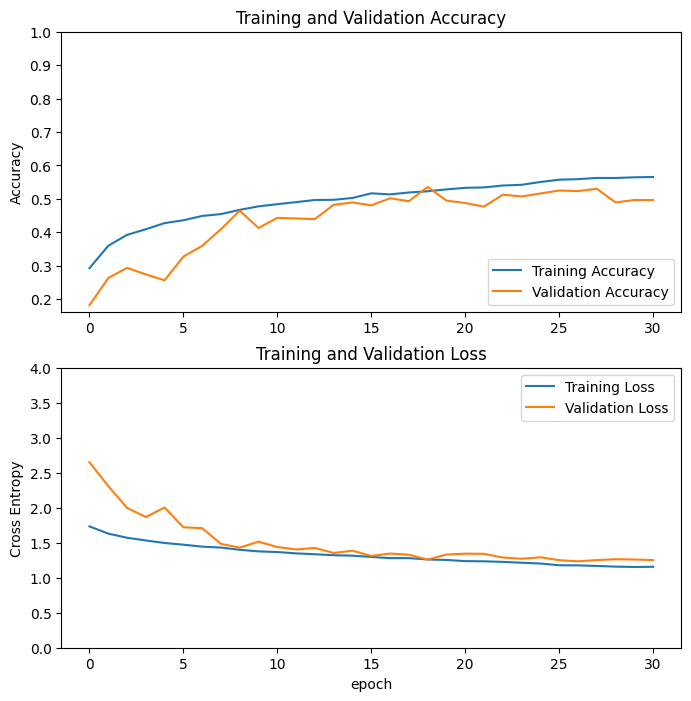

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Save your best performing model, and upload the save file to Google Classroom along with your submission

